<center><font size="6">Case 1. Heart Disease Classification</font></center>

<center><font size="4">Sakari Helokunnas</font></center>

<center><font size="3">3.2.2019</font></center>

<center><font size="5">Helsinki Metropolia University of Applied Sciences </font></center>

<font size="5">Objectives</font><br>
<u>Assignment goal</u>: Train keras neural network to predict heart disease status<br>
<u>Own goal</u>: Optimize neural network training parameters for minimal loss deviation between training set and validation set<br>

<font size="5">Data Notes</font><br>
Data was in four parts, total 920 rows.<br>
Some missing data, mainly parameters 12 and 13.<br>


<font size="5">Dataset parameters</font>
    1. age            age in years
    2. sex            sex
    3. cp             chest pain type
    4. trestbps       resting blood pressure
    5. chol           serum cholestoral
    6. fbs fasting    blood sugar
    7. restecg        resting electrocardiographic results
    8. thalach        maximum heart rate achieved
    9. exang          exercise induced angina
    10. oldpeak       ST depression induced by exercise relative to rest
    11. slope         the slope of the peak exercise ST segment
    12. ca            number of major vessels (0-3) colored by flourosopy
    13. thal          3 = normal; 6 = fixed defect; 7 = reversable defect
    14. num           diagnosis of heart disease (predicted)



<font size="5">Imports</font>

In [53]:
%pylab inline
import pandas as pd
import sklearn.utils as skuti
from sklearn.model_selection import KFold
import time as time

from keras import models
from keras import layers
from keras import optimizers

Populating the interactive namespace from numpy and matplotlib


<font size="5">Data URLs</font>

In [33]:
url1 = r'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
url2 = r'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data'
url3 = r'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data'
url4 = r'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data'

<font size="5">Defining data reading methods </font>
<font size="3">(note shuffle here)</font>

In [40]:
#Data division parameters
dataBreakpoint1 = 460 # training/validation
dataBreakpoint2 = 690 # validation/testing
dataMin = 0 # starting point, usually 0
dataMax = 920 # ending point, should be the count of values in all data

kfoldBreakpoint = 820 # breakpoint between kfolded data and separate evaluation data

class Dataset(object):
    def __init__(self, original, values, labels):
        self.original = original
        self.values = values
        self.labels = labels

def readUrl(url):
    dataframe = pd.read_csv(url, 
                            sep = ',', 
                            header = None, 
                            index_col = None,
                            na_values = '?')
    dataframe = dataframe.fillna(dataframe.median())
    name_list = ['age', 'sex', 'cp','trestbps', 'chol', 'fbs','restecg',
             'thalac','exang','oldpeak','slope','ca','thal','num']
    dataframe.columns = name_list
    return dataframe

def readAllData():
    #combining all data
    data = readUrl(url1).append(readUrl(url2).append(readUrl(url3).append(readUrl(url4), ignore_index=True), ignore_index=True), ignore_index=True)
    #data = data.sample(frac=1)
    data = skuti.shuffle(data) # randomize rows
    train_labels_nums = data['num']
    train_labels = []
    for x in train_labels_nums:
        lista = []
        for z in range(2): # fill out the list
            lista.append(0.0)
        if x > 0: # any amount of disease is a disease
            lista[1] = 1.0
        else: # rest are no-disease
            lista[0] = 1.0
        train_labels.append(lista)
    train_labels = pd.DataFrame(data=train_labels)
    train_data = data.drop(['num'], axis=1)
    return Dataset(data, train_data, train_labels)

<font size="5">Read data and Check data correlation</font>

In [41]:
allData = readAllData()
allData.original.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
age,1.000000,0.056889,0.166245,0.230845,-0.088799,0.219915,0.213651,-0.375075,0.230415,0.267040,0.077087,0.210302,0.129752,0.339596
sex,0.056889,1.000000,0.170392,-0.002449,-0.195080,0.075370,-0.016442,-0.194053,0.206185,0.116587,0.105805,0.065170,0.336347,0.259342
cp,0.166245,0.170392,1.000000,0.023910,-0.133910,0.021265,0.032288,-0.333174,0.386499,0.226172,0.110992,0.210821,0.207602,0.397896
trestbps,0.230845,-0.002449,0.023910,1.000000,0.090883,0.143936,0.095496,-0.098139,0.137255,0.153323,0.050265,-0.000638,0.028193,0.112128
chol,-0.088799,-0.195080,-0.133910,0.090883,1.000000,0.087453,0.109356,0.224977,-0.035750,0.046804,-0.032356,-0.441546,-0.193208,-0.233732
fbs,0.219915,0.075370,0.021265,0.143936,0.087453,1.000000,0.142750,-0.056995,0.076999,0.075561,0.070830,-0.045557,0.086715,0.129539
restecg,0.213651,-0.016442,0.032288,0.095496,0.109356,0.142750,1.000000,0.042089,0.045707,0.123870,-0.043313,0.084869,-0.101452,0.139997
thalac,-0.375075,-0.194053,-0.333174,-0.098139,0.224977,-0.056995,0.042089,1.000000,-0.382328,-0.161634,-0.299105,-0.138015,-0.329817,-0.359713
exang,0.230415,0.206185,0.386499,0.137255,-0.035750,0.076999,0.045707,-0.382328,1.000000,0.406736,0.223259,0.006090,0.285978,0.376892
oldpeak,0.267040,0.116587,0.226172,0.153323,0.046804,0.075561,0.123870,-0.161634,0.406736,1.000000,0.270972,0.066492,0.215003,0.421671


<font size="5">Drop _fbs_, _restecg_ and _trestbps_ as very low correlation. Then Normalize data.</font>

In [55]:
mega_values = allData.values.drop(columns=['fbs','restecg', 'trestbps'])
mega_labels = allData.labels
mega_values = (mega_values - mega_values.mean()) / (mega_values.std())

#Alternate normalizing functions, tested but yielded worse results
#mega_values = (mega_values - mega_values.mean(axis=0)) / (mega_values.max() - mega_values.min())
#mega_values = (mega_values - mega_values.min()) / (mega_values.max() - mega_values.min())

<font size="5">Organize data to sets</font>

In [57]:
#non-kfold sets
training_set = mega_values[dataMin:dataBreakpoint1]
training_labels = mega_labels[dataMin:dataBreakpoint1]
validation_set = mega_values[dataBreakpoint1:dataBreakpoint2]
validation_labels = mega_labels[dataBreakpoint1:dataBreakpoint2]
testing_set = mega_values[dataBreakpoint2:dataMax]
testing_labels = mega_labels[dataBreakpoint2:dataMax]

training_set = (training_set - training_set.mean()) / (training_set.std())
training_set = (validation_set - training_set.mean()) / (training_set.std())
training_set = (testing_set - training_set.mean()) / (training_set.std())

#kfold sets
kfoldSet_values = mega_values[dataMin:kfoldBreakpoint]
kfoldSet_labels = mega_labels[dataMin:kfoldBreakpoint]
kfoldEvaluate_values = mega_values[kfoldBreakpoint:dataMax]
kfoldEvaluate_labels = mega_labels[kfoldBreakpoint:dataMax]

#kfoldSet_values = (kfoldSet_values - kfoldSet_values.mean()) / (kfoldSet_values.std())
#kfoldEvaluate_values = (kfoldEvaluate_values - kfoldSet_values.mean()) / (kfoldSet_values.std())

<font size="5">Create, Train and Validate the neural network.</font>

Fold 1 done. TestAcc: 0.816 | ValidationAcc: 0.780 | EvaluationAcc: 0.830
Final loss deviation: -0.018
Fit time: 4.001


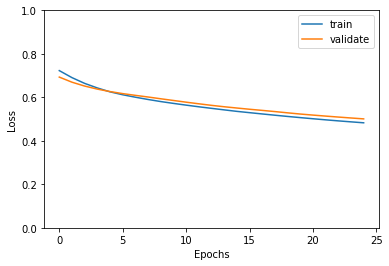

Fold 2 done. TestAcc: 0.829 | ValidationAcc: 0.849 | EvaluationAcc: 0.830
Final loss deviation: 0.030
Fit time: 4.132


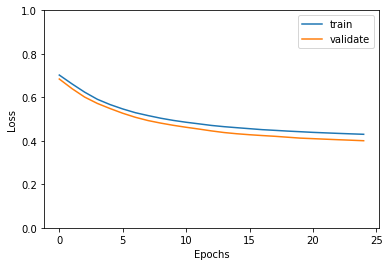

Fold 3 done. TestAcc: 0.828 | ValidationAcc: 0.839 | EvaluationAcc: 0.800
Final loss deviation: -0.006
Fit time: 4.025


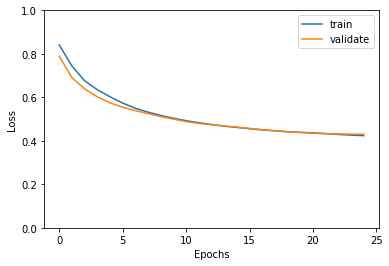

Fold 4 done. TestAcc: 0.834 | ValidationAcc: 0.805 | EvaluationAcc: 0.810
Final loss deviation: -0.010
Fit time: 4.052


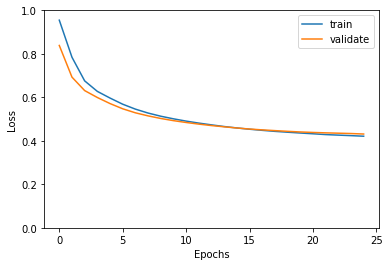

Full time: 17.4111


In [62]:
#NOTES:
#Density: 1000 is way too high, 200 is probably always too high, 10 seems to get underfit

#set1: 60/100/20, over 80%, constantly decent, 90s total
#set2: 20/20/14, over 80 but sometimes produces underfit / data-anomaly curve?

#Parameters
layer1Density = 50
batch = 100
epoch = 25
kfoldSplits = 4
trainSingle = False # False is way to go
#ParametersEnd


kfold = KFold(n_splits=kfoldSplits) #Create KFold splits (indices)

optimizer = optimizers.Adam(lr = 0.0004)

#Different optimizers used, yielded generally same or worse results
#optimizer = optimizers.SGD(lr = 0.1)
#optimizer = optimizers.SGD(lr = 0.008, nesterov=True)
#optimizer = optimizers.RMSprop()

def createNetwork():
    network = models.Sequential()
    network.add(layers.Dense(layer1Density, activation='sigmoid', input_shape=(len(kfoldSet_values.columns),)))
    network.add(layers.Dense(2, activation='softmax'))
    network.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy'])
    return network

startTime = time.time()
i = 0
if trainSingle:
    network = createNetwork()
    
for train, validate in kfold.split(kfoldSet_values):
    i+=1
    if trainSingle == False:
        network = createNetwork()

    #network.summary()
    #network.fit(training_set, training_labels, batch_size=batch, epochs=epoch, validation_data=(validation_set, validation_labels))
    fitTimeStart = time.time()
    fitHistory = network.fit(kfoldSet_values.iloc[train], kfoldSet_labels.iloc[train], batch_size=batch, epochs=epoch, validation_data=(kfoldSet_values.iloc[validate], kfoldSet_labels.iloc[validate]), verbose=0)
    fitTimeEnd = time.time()
    evaHistory = network.evaluate(kfoldEvaluate_values, kfoldEvaluate_labels, verbose=0)
    print("Fold %d done. TestAcc: %0.3f | ValidationAcc: %0.3f | EvaluationAcc: %0.3f" % (i, fitHistory.history['acc'][-1], fitHistory.history['val_acc'][-1], evaHistory[1]))
    print("Final loss deviation: %0.3f" % (fitHistory.history['loss'][-1]-fitHistory.history['val_loss'][-1]))
    print("Fit time: %0.3f" % (fitTimeEnd-fitTimeStart))
    plt.figure()
    plt.plot(fitHistory.history['loss'])
    plt.plot(fitHistory.history['val_loss'])
    plt.legend(['train', 'validate'], loc='upper right')
    plt.ylim(0.0, 1.0)
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.show()
endTime = time.time()
print("Full time: %0.4f" % (endTime-startTime))

<font size="5">Result explanation</font><br>
<u>KFold usage</u>: Data is separated into 4 parts, each "fold" has 3 parts training and 1 part validating. <br>Each "fold" creates a fresh neural network. (Parameter "trainSingle = False")<br>
<br>
**<u>Result parameters</u>**<br>
<u>TestAcc</u>: Accuracy achieved for training set (last epoch)<br>
<u>ValidationAcc</u>: Accuracy achieved for validation set<br>
<u>EvaluationAcc</u>: Accuracy achieved for constant evaluation set, no overlap with KFold sets. Used to verify that each KFold learns about the same things.<br>
<br>
<u>FinalLossDeviation</u>: Loss function difference, between training and validation sets, at the end of last epoch. Used to verify how closely model<br>
<u>FitTime</u>: Time it took for this KFold to execute (in seconds).<br>
<u>Full time</u>: Total time for the whole KFold cell.<br>

<font size="5">Testing result observations</font><br>
**<u>Data manipulation:</u><br>**
    Dropping dropped columns raised average accuracy by about 1%~, so it was pretty neligible.<br>
    Droppint columns _ca_ and _thal_ only worsened the accuracy by 2-4%, even though they were severely under represented in the data.<br>
    Didn't test dropping rows that have many missing values.<br>
<br>
**<u>Neural Network Model manipulation:</u><br>**
<u>First layer density</u>: 1000 is way too big, and under 10 seems to underfit. Around 20 sometimes got training anomalies (no smooth curves). 40-80 seems to yield similarly decent results.<br>
<u>Batch and epochs</u>: Bigger batch and more epochs seemed to yield more stable results. Sometimes smaller batch and less epochs got to same accuracy faster, but this method had more variation.<br>
<u>KFold amount</u>: Inconsistency rises with more KFolds, due to validation set becoming increasingly small. 25% (with 4 KFolds) is still quite ok validation set. 3 folds seemed to work similraly to 4 folds.<br>
<u>Optimizers</u>: Tested few different, but ultimately Adam with low learning rate got the smoothest curves. I got either inconsistent or less accurate results with others, even with similarly low learning rates.

<font size="5">Conclusion</font><br>
Given the quality and amount of data, in addition to the testing done, the result of average 82% accuracy is good enough.
Deviation in loss deviatation got ironed out (no longer random 0.1 or higher deviation).<br>
Curves are smooth, training times are relatively fast. With more (and more consistent) data, I think this could get better results.<br>